<a href="https://www.kaggle.com/code/aabdollahii/multilingual-mobile-app-review-sentiment?scriptVersionId=256311334" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/multilingual-mobile-app-reviews-dataset-2025/multilingual_mobile_app_reviews_2025.csv


# loading data and understanding about it

In [2]:
import pandas as pd
DATA_PATH = "/kaggle/input/multilingual-mobile-app-reviews-dataset-2025/multilingual_mobile_app_reviews_2025.csv"
df = pd.read_csv(DATA_PATH)

In [3]:
df.shape

(2514, 15)

In [4]:
df.columns.tolist()

['review_id',
 'user_id',
 'app_name',
 'app_category',
 'review_text',
 'review_language',
 'rating',
 'review_date',
 'verified_purchase',
 'device_type',
 'num_helpful_votes',
 'user_age',
 'user_country',
 'user_gender',
 'app_version']

- We probably remove user_id, reveiw_id, depend on project goals we set in future. 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2514 entries, 0 to 2513
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   review_id          2514 non-null   int64  
 1   user_id            2514 non-null   int64  
 2   app_name           2514 non-null   object 
 3   app_category       2514 non-null   object 
 4   review_text        2455 non-null   object 
 5   review_language    2514 non-null   object 
 6   rating             2477 non-null   float64
 7   review_date        2514 non-null   object 
 8   verified_purchase  2514 non-null   bool   
 9   device_type        2514 non-null   object 
 10  num_helpful_votes  2514 non-null   int64  
 11  user_age           2514 non-null   float64
 12  user_country       2473 non-null   object 
 13  user_gender        1927 non-null   object 
 14  app_version        2484 non-null   object 
dtypes: bool(1), float64(2), int64(3), object(9)
memory usage: 277.6+ KB


- lots of objects in data set.We do not need to convert all of them to numeric.

In [6]:
df.head()

,review_id,user_id,app_name,app_category,review_text,review_language,rating,review_date,verified_purchase,device_type,num_helpful_votes,user_age,user_country,user_gender,app_version
0,1,1967825,MX Player,Travel & Local,Qui doloribus consequuntur. Perspiciatis tempo...,no,1.3,2024-10-09 19:26:40,True,Android Tablet,65,14.0,China,Female,1.4
1,2,9242600,Tinder,Navigation,"Great app but too many ads, consider premium v...",ru,1.6,2024-06-21 17:29:40,True,iPad,209,18.0,Germany,Male,8.9
2,3,7636477,Netflix,Dating,The interface could be better but overall good...,es,3.6,2024-10-31 13:47:12,True,iPad,163,67.0,Nigeria,Male,2.8.37.5926
3,4,209031,Venmo,Productivity,"Latest update broke some features, please fix ...",vi,3.8,2025-03-12 06:16:22,True,iOS,664,66.0,India,Female,10.2
4,5,7190293,Google Drive,Education,"Perfect for daily use, highly recommend to eve...",tl,3.2,2024-04-21 03:48:27,True,iPad,1197,40.0,South Korea,Prefer not to say,4.7


- I see some problems in the first 5 rows, like Netflix categories and ....... but anyway, we are gonna work on this just for fun and practice.

In [7]:
if 'review_language' in df.columns:
    print("==== Sample Reviews by Language ====")
    print(df.groupby('review_language').head(1)[['review_language', 'review_text']])

==== Sample Reviews by Language ====
   review_language                                        review_text
0               no  Qui doloribus consequuntur. Perspiciatis tempo...
1               ru  Great app but too many ads, consider premium v...
2               es  The interface could be better but overall good...
3               vi  Latest update broke some features, please fix ...
4               tl  Perfect for daily use, highly recommend to eve...
5               th  Works perfectly on my device, no complaints at...
6               da  Basso bello società paese. Quello mostrare verso.
7               ja  Odcinek skład zarówno zgodnie zaś. Powoli gdyb...
8               ms  Eius odio facilis fuga distinctio eaque. Non c...
9               fr       Husband at tree note responsibility defense.
10              it  Works perfectly on my device, no complaints at...
11              nl  The interface could be better but overall good...
13              hi  Some bugs need fixing but general

* 2514 rows, 15 columns — small enough to experiment easily without GPU.
The mix of review text, app metadata, user demographics, and technical details (device type, app version) gives us plenty of potential features.
* review_text → 59 missing (2.3%).
rating → 37 missing (1.47%) — important since this is our sentiment target.
user_country → 41 missing.
user_gender → 587 missing (23%) — gender might be unreliable for modeling.
app_version → 30 missing.
* review_language shows a wide multilingual spread (no, ru, es, vi, tl, th, da, ja, ms, fr, it, nl, hi, ar, zh, id, pl, ko, sv, pt, tr, fi, de, en… and probably more).
* This will test our multilingual NLP preprocessing — possibly requiring:
Translation to a single language (English) or
Multilingual transformer embeddings.
* Some reviews look auto-generated or synthetic (a few are unrelated phrases).
→ Could be synthetic dataset creation — fine for practice, but don’t expect real linguistic distribution.

# making data ready for sentiment analysis

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

#  Drop rows with missing review_text or rating
df = df.dropna(subset=['review_text', 'rating']).reset_index(drop=True)



In [9]:
#  Create sentiment label
def rating_to_sentiment(r):
    if r >= 4.0:
        return "Positive"
    elif r >= 3.0:
        return "Neutral"
    else:
        return "Negative"

df['sentiment'] = df['rating'].apply(rating_to_sentiment)

In [10]:
#  Check distribution
print("Sentiment Counts:")
print(df['sentiment'].value_counts())

Sentiment Counts:
sentiment
Negative    1171
Positive     630
Neutral      617
Name: count, dtype: int64


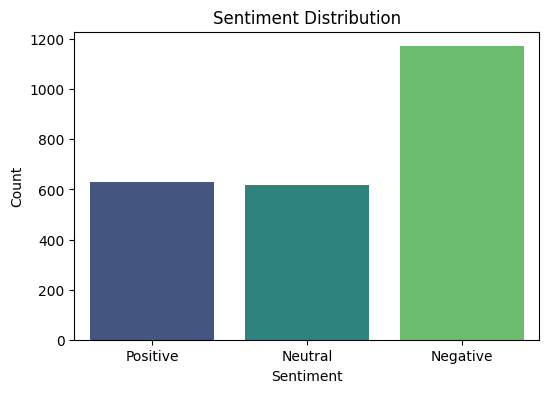

In [11]:
# Plot
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='sentiment', order=['Positive','Neutral','Negative'], palette='viridis')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

- as you can see, most of the data is negative. Maybe this is not suitable for ML models. it’s not extreme enough to kill model performance.

# explore the multilingual side

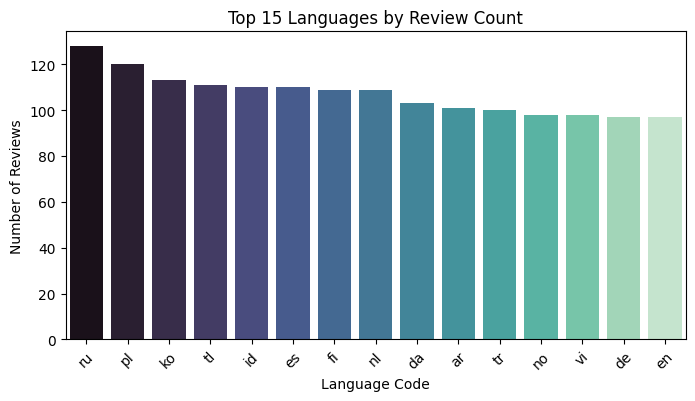

In [12]:
# Top languages by review count
lang_counts = df['review_language'].value_counts().head(15)
plt.figure(figsize=(8,4))
sns.barplot(x=lang_counts.index, y=lang_counts.values, palette='mako')
plt.title("Top 15 Languages by Review Count")
plt.xlabel("Language Code")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.show()

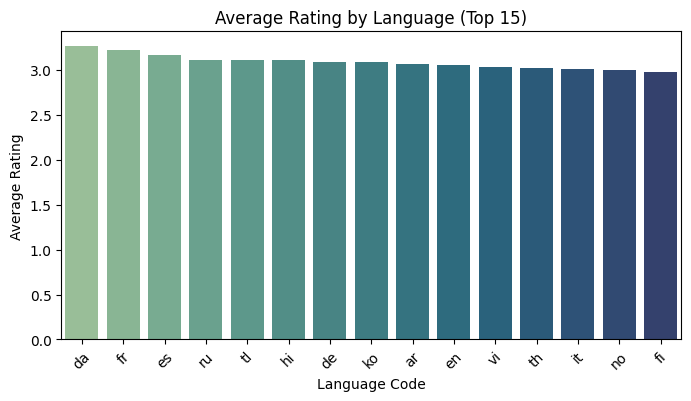

In [13]:
# 2 — Average rating by language (top 15 languages)
avg_rating = df.groupby('review_language')['rating'].mean().sort_values(ascending=False).head(15)
plt.figure(figsize=(8,4))
sns.barplot(x=avg_rating.index, y=avg_rating.values, palette='crest')
plt.title("Average Rating by Language (Top 15)")
plt.xlabel("Language Code")
plt.ylabel("Average Rating")
plt.xticks(rotation=45)
plt.show()

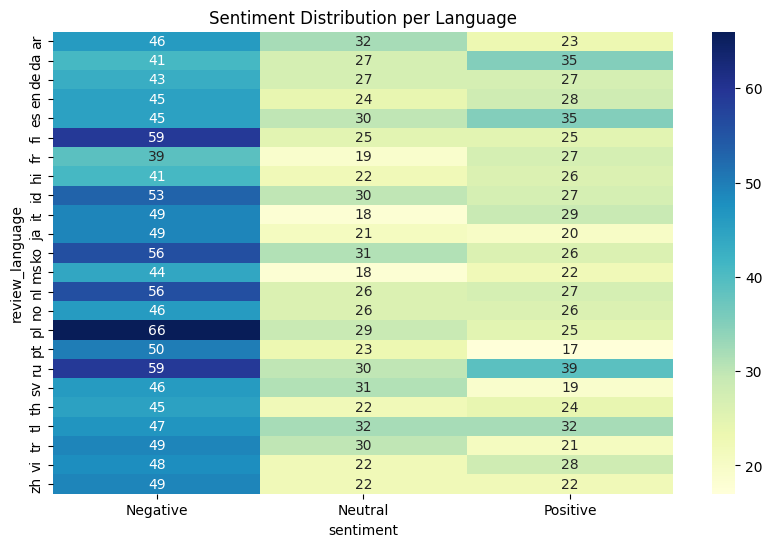

In [14]:
# Sentiment count by language heatmap
sent_lang = df.groupby(['review_language','sentiment'])['sentiment'].count().unstack().fillna(0)
plt.figure(figsize=(10,6))
sns.heatmap(sent_lang, annot=True, fmt='g', cmap='YlGnBu')
plt.title("Sentiment Distribution per Language")
plt.show()